- Kontrolna tačka 2 - Analiza podataka i baseline model

Cilj ove faze je analiza skupa podataka sa slikama Pokemona i implementacija osnovnog klasifikacionog modela koji će poslužiti kao baseline za dalji rad. U okviru ove kontrolne tačke biće prikazane karakteristike skupa podataka, sprovedeno pretprocesiranje, vizualizacija uzoraka i evaluacija jednostavnog CNN modela za klasifikaciju Pokemona. Rezultati ovog baseline modela biće korišćeni za poređenje sa kasnijim GAN modelom u CP3.

In [3]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [8]:
!ls "/content/drive/MyDrive/" | grep -i pokemon

Pokemon_GAN.zip


In [4]:
import zipfile
import os

# Putanja do zip fajla na Drive-u
zip_path = '/content/drive/MyDrive/Pokemon_GAN.zip'

# Putanja gde će se raspakovati (u Colab okruženju)
extract_path = '/content/pokemon_slike'

# Kreiranje foldera za raspakivanje ako ne postoji
os.makedirs(extract_path, exist_ok=True)

# Raspakivanje zip-a
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print(f" Zip fajl uspešno raspakovan u: {extract_path}")

# Proveriti šta je raspakovano
files = os.listdir(extract_path)
print(f"\nBroj fajlova/foldera nakon raspakivanja: {len(files)}")
print(f"Prvih 10: {files[:10]}")

# Postavlja base_path na raspakovani folder
base_path = extract_path + '/'
print(f"\n🔹 base_path je sada: {base_path}")

 Zip fajl uspešno raspakovan u: /content/pokemon_slike

Broj fajlova/foldera nakon raspakivanja: 2
Prvih 10: ['pokemon_jpg', 'pokemon']

🔹 base_path je sada: /content/pokemon_slike/


In [6]:
if len(files) == 1 and os.path.isdir(os.path.join(extract_path, files[0])):

    base_path = os.path.join(extract_path, files[0]) + '/'
    print(f"🔹 Slike su u podfolderu: {base_path}")

# Proverava da li postoje slike
import glob
image_files = glob.glob(base_path + '*.*')
print(f"\nBroj slika u base_path: {len([f for f in image_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])}")

# Prikazuje nekoliko primera
print(f"\nPrimeri fajlova:")
for f in sorted(os.listdir(base_path))[:20]:
    print(f"  - {f}")


Broj slika u base_path: 0

Primeri fajlova:
  - pokemon
  - pokemon_jpg


In [7]:
import os

# Pretražuje rekurzivno sve foldere
base_search = '/content/pokemon_slike/'

print("Tražim slike...")
for root, dirs, files in os.walk(base_search):
    # Proverava da li ima slika u trenutnom folderu
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if image_files:
        print(f"\n Pronađene slike u: {root}")
        print(f"   Broj slika: {len(image_files)}")
        print(f"   Prve 3: {image_files[:3]}")
        break
    print("Folder NE postoji!")

Tražim slike...
Folder NE postoji!
Folder NE postoji!

 Pronađene slike u: /content/pokemon_slike/pokemon_jpg/pokemon_jpg
   Broj slika: 819
   Prve 3: ['54.jpg', '706.jpg', '201-f.jpg']


In [8]:
# Putanja za JPG slike
jpg_folder = '/content/pokemon_slike/pokemon_jpg/pokemon_jpg/'

# Proverava da li postoji
if os.path.exists(jpg_folder):
    print(f"JPG folder postoji!")
    jpg_files = os.listdir(jpg_folder)
    print(f"Broj fajlova: {len(jpg_files)}")
    print(f"Prvih 5: {jpg_files[:5]}")
else:
    print(f" JPG folder ne postoji. Tragamo dalje...")

    # Ako ne postoji, pretraži
    import glob
    jpg_images = glob.glob('/content/pokemon_slike/**/*.jpg', recursive=True)
    print(f"Pronađeno JPG slika: {len(jpg_images)}")
    if jpg_images:
        print(f"Prva JPG slika: {jpg_images[0]}")

JPG folder postoji!
Broj fajlova: 819
Prvih 5: ['54.jpg', '706.jpg', '201-f.jpg', '150-mega-x.jpg', '48.jpg']


In [9]:
# Putanja do JPG slika
base_path = '/content/pokemon_slike/pokemon_jpg/pokemon_jpg/'
print(f"Radimo sa folderom: {base_path}")

Radimo sa folderom: /content/pokemon_slike/pokemon_jpg/pokemon_jpg/


In [10]:
# Učitavanje biblioteka
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

print(" Biblioteke uspešno učitane!")
print(f"TensorFlow verzija: {tf.__version__}")

 Biblioteke uspešno učitane!
TensorFlow verzija: 2.19.0


In [11]:
# Putanja do JPG slika
base_path = '/content/pokemon_slike/pokemon_jpg/pokemon_jpg/'

# Provera da li putanja postoji
if os.path.exists(base_path):
    files = os.listdir(base_path)
    print(f"Putanja postoji: {base_path}")
    print(f" Broj fajlova u folderu: {len(files)}")
    print(f" Primeri: {files[:5]}")
else:
    print(f" Putanja NE postoji: {base_path}")

Putanja postoji: /content/pokemon_slike/pokemon_jpg/pokemon_jpg/
 Broj fajlova u folderu: 819
 Primeri: ['54.jpg', '706.jpg', '201-f.jpg', '150-mega-x.jpg', '48.jpg']


In [12]:
# Liste za čuvanje podataka
image_paths = []
labels = []
pokemon_ids = []
variants = []

# Prolazak kroz sve JPG slike
for filename in os.listdir(base_path):
    if filename.lower().endswith(('.jpg', '.jpeg')):
        # Puna putanja
        img_path = os.path.join(base_path, filename)
        image_paths.append(img_path)

        # Ime fajla bez ekstenzije
        name_without_ext = os.path.splitext(filename)[0]

        # Izdvajanje labele
        if '-' in name_without_ext:
            parts = name_without_ext.split('-')
            pokemon_id = parts[0]
            variant = '-'.join(parts[1:])  # u slučaju da ima više crtica
        else:
            pokemon_id = name_without_ext
            variant = 'basic'

        pokemon_ids.append(pokemon_id)
        variants.append(variant)
        labels.append(name_without_ext)

# Kreiranje DataFrame-a
df = pd.DataFrame({
    'image_path': image_paths,
    'pokemon_id': pokemon_ids,
    'variant': variants,
    'full_label': labels
})

print(f" Ukupno učitano slika: {len(df)}")
print("\n Prvih 10 redova:")
print(df.head(10))

 Ukupno učitano slika: 819

 Prvih 10 redova:
                                          image_path pokemon_id variant  \
0  /content/pokemon_slike/pokemon_jpg/pokemon_jpg...         54   basic   
1  /content/pokemon_slike/pokemon_jpg/pokemon_jpg...        706   basic   
2  /content/pokemon_slike/pokemon_jpg/pokemon_jpg...        201       f   
3  /content/pokemon_slike/pokemon_jpg/pokemon_jpg...        150  mega-x   
4  /content/pokemon_slike/pokemon_jpg/pokemon_jpg...         48   basic   
5  /content/pokemon_slike/pokemon_jpg/pokemon_jpg...        237   basic   
6  /content/pokemon_slike/pokemon_jpg/pokemon_jpg...        384   basic   
7  /content/pokemon_slike/pokemon_jpg/pokemon_jpg...         15    mega   
8  /content/pokemon_slike/pokemon_jpg/pokemon_jpg...        646   black   
9  /content/pokemon_slike/pokemon_jpg/pokemon_jpg...        633   basic   

   full_label  
0          54  
1         706  
2       201-f  
3  150-mega-x  
4          48  
5         237  
6         384  


In [17]:
#Karakteristike
print("\n" + "="*60)
print(" KARAKTERISTIKE SKUPA PODATAKA")
print("="*60)
print(f"Ukupan broj slika: {len(df)}")
print(f"Broj različitih Pokemon ID-jeva: {df['pokemon_id'].nunique()}")
print(f"Broj različitih punih labela: {df['full_label'].nunique()}")
print(f"Broj različitih varijanti: {df['variant'].nunique()}")

# Prikaz prvih nekoliko varijanti
print("\n 20 najčešćih varijanti:")
print(df['variant'].value_counts().head(20))

# Provera dimenzija slika
sample_img = Image.open(df['image_path'].iloc[0])
print(f"\n Dimenzije prve slike: {sample_img.size}")
print(f" Mod boje: {sample_img.mode}")

# Provera da li su sve slike iste veličine
print("\n Provera dimenzija svih slika (uzorak 50):")
sizes = []
for path in df['image_path'].sample(min(50, len(df))):
    with Image.open(path) as img:
        sizes.append(img.size)

unique_sizes = set(sizes)
if len(unique_sizes) == 1:
    print(f" Sve slike su iste veličine: {unique_sizes.pop()}")
else:
    print(f" Slike imaju različite veličine: {unique_sizes}")


 KARAKTERISTIKE SKUPA PODATAKA
Ukupan broj slika: 819
Broj različitih Pokémon ID-jeva: 726
Broj različitih punih labela: 819
Broj različitih varijanti: 52

 20 najčešćih varijanti:
variant
basic        708
mega          44
incarnate      3
therian        3
spring         2
plant          2
east           2
normal         2
trash          2
sandy          2
autumn         2
winter         2
primal         2
mega-y         2
summer         2
mega-x         2
west           2
black          1
frost          1
f              1
Name: count, dtype: int64

 Dimenzije prve slike: (256, 256)
 Mod boje: RGB

 Provera dimenzija svih slika (uzorak 50):
 Sve slike su iste veličine: (256, 256)



ANALIZA BALANSIRANOSTI
Prosečan broj slika po Pokémon-u: 1.13
Medijana: 1.0
Min: 1
Max: 6
Standardna devijacija: 0.47

 10 najzastupljenijih Pokémon-a:
  pokemon_id  count
0        479      6
1         25      6
2        676      4
3        585      4
4        386      4
5        586      4
6        646      3
7          6      3
8        413      3
9        412      3

 10 najmanje zastupljenih Pokémon-a:
    pokemon_id  count
716        567      1
717        154      1
718        656      1
719        173      1
720        270      1
721        573      1
722        290      1
723        436      1
724        123      1
725        721      1


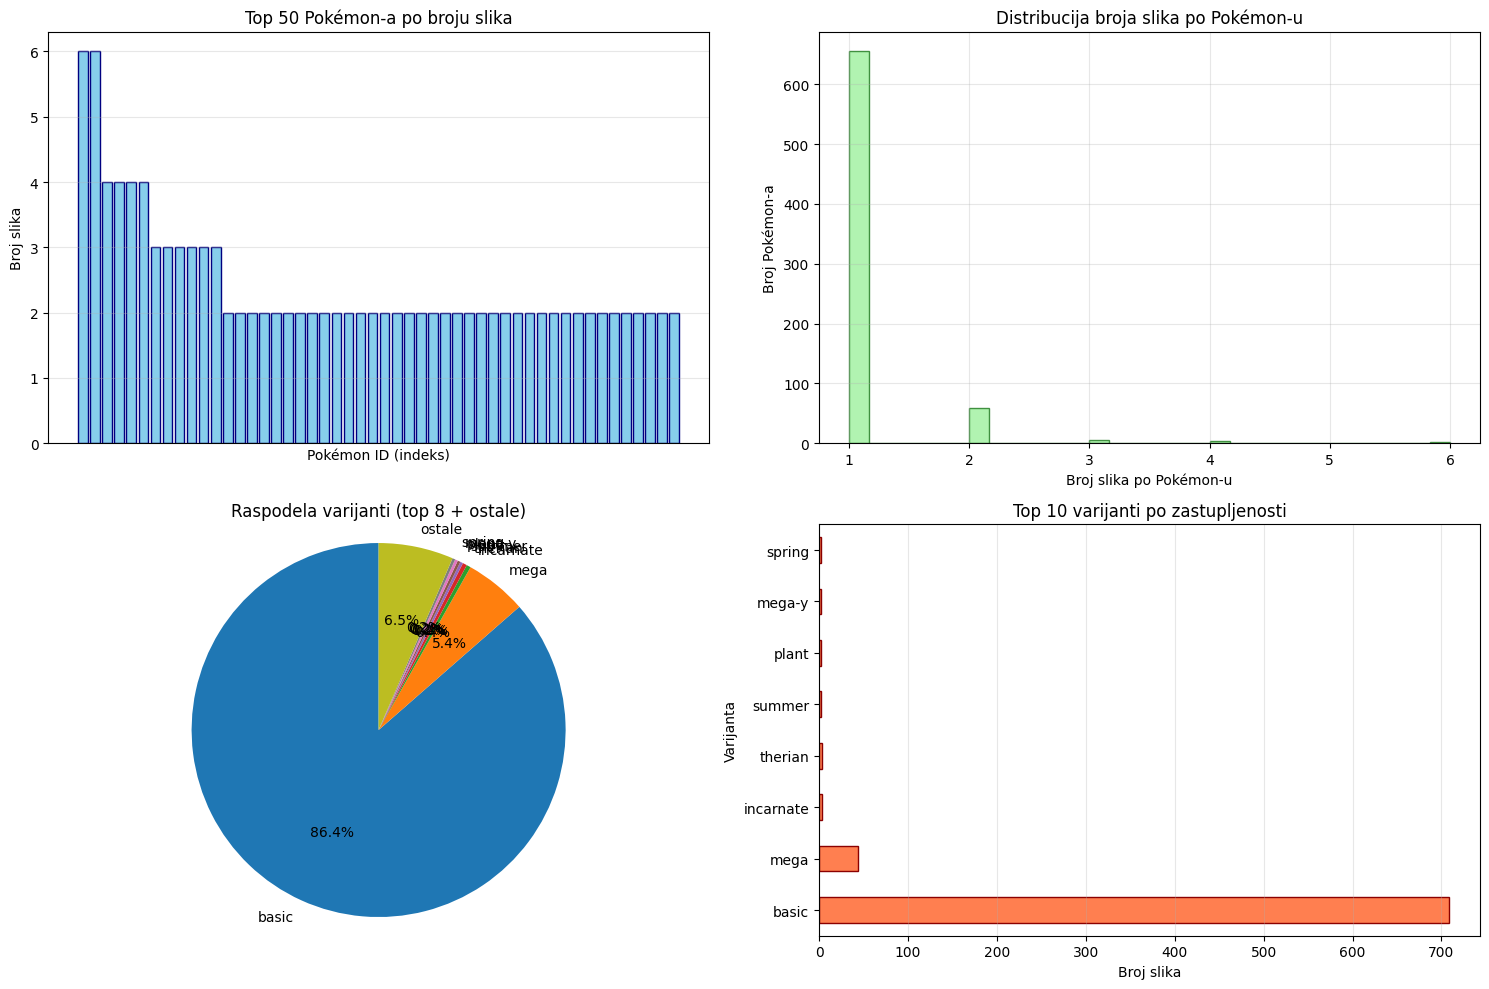

In [18]:
# Analiza balansiranosti - koliko slika po Pokemon ID-u
id_counts = df['pokemon_id'].value_counts().reset_index()
id_counts.columns = ['pokemon_id', 'count']

print("\n" + "="*60)
print("ANALIZA BALANSIRANOSTI")
print("="*60)
print(f"Prosečan broj slika po Pokemon-u: {id_counts['count'].mean():.2f}")
print(f"Medijana: {id_counts['count'].median()}")
print(f"Min: {id_counts['count'].min()}")
print(f"Max: {id_counts['count'].max()}")
print(f"Standardna devijacija: {id_counts['count'].std():.2f}")

# Prikaz 10 najzastupljenijih Pokemon-a
print("\n 10 najzastupljenijih Pokemon-a:")
print(id_counts.head(10))

# Prikaz 10 najmanje zastupljenih Pokemon-a
print("\n 10 najmanje zastupljenih Pokemon-a:")
print(id_counts.tail(10))

# Vizualizacija
plt.figure(figsize=(15, 10))

# Bar chart za prvih 50 Pokemon-a
plt.subplot(2, 2, 1)
top_50 = id_counts.head(50)
plt.bar(range(len(top_50)), top_50['count'].values, color='skyblue', edgecolor='navy')
plt.xlabel('Pokemon ID (indeks)')
plt.ylabel('Broj slika')
plt.title('Top 50 Pokemon-a po broju slika')
plt.xticks([])
plt.grid(True, alpha=0.3, axis='y')

# Histogram raspodele
plt.subplot(2, 2, 2)
plt.hist(id_counts['count'], bins=30, color='lightgreen', edgecolor='darkgreen', alpha=0.7)
plt.xlabel('Broj slika po Pokemon-u')
plt.ylabel('Broj Pokemon-a')
plt.title('Distribucija broja slika po Pokemon-u')
plt.grid(True, alpha=0.3)

# Pie chart za varijante (top 10)
plt.subplot(2, 2, 3)
variant_counts = df['variant'].value_counts()
top_variants = variant_counts.head(8)  # Uzima top 8
others = pd.Series({'ostale': variant_counts[8:].sum()})
pie_data = pd.concat([top_variants, others])
plt.pie(pie_data.values, labels=pie_data.index, autopct='%1.1f%%', startangle=90)
plt.title('Raspodela varijanti (top 8 + ostale)')
plt.axis('equal')

# Bar chart za varijante
plt.subplot(2, 2, 4)
top_variants.plot(kind='barh', color='coral', edgecolor='darkred')
plt.xlabel('Broj slika')
plt.ylabel('Varijanta')
plt.title('Top 10 varijanti po zastupljenosti')
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [19]:
# Funkcija za prikaz mreže slika
def plot_sample_images(df, title_prefix="Primeri", n_samples=16, cols=4):
    rows = (n_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.ravel()

    # Nasumičan odabir uzorka
    samples = df.sample(n_samples)

    for i, (idx, row) in enumerate(samples.iterrows()):
        img = Image.open(row['image_path'])
        axes[i].imshow(img)
        axes[i].set_title(f"{row['full_label']}", fontsize=8)
        axes[i].axis('off')

    # Sakriva prazne podgrafike
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"{title_prefix} - {n_samples} nasumičnih slika", fontsize=14)
    plt.tight_layout()
    plt.show()

# 1. Prikaz nasumičnih uzoraka
plot_sample_images(df, "Nasumični uzorci", 16)

# 2. Prikaz primera osnovnih formi (basic)
basic_df = df[df['variant'] == 'basic']
print(f"\n Prikazujem 8 primera osnovnih formi (basic):")
plot_sample_images(basic_df, "Osnovne forme (basic)", 8)

# 3. Prikaz mega varijanti
mega_df = df[df['variant'].str.contains('mega', na=False)]
if len(mega_df) > 0:
    print(f"\n Prikazujem mega varijante (ukupno {len(mega_df)}):")
    plot_sample_images(mega_df, "Mega varijante", min(8, len(mega_df)))

# 4. Prikaz Pikachu kostima (ako postoje)
pikachu_costumes = df[df['pokemon_id'] == '25']
if len(pikachu_costumes) > 1:
    print(f"\n Prikazujem Pikachu varijante (ukupno {len(pikachu_costumes)}):")
    plot_sample_images(pikachu_costumes, "Pikachu kostimi", min(8, len(pikachu_costumes)))

Output hidden; open in https://colab.research.google.com to view.

In [22]:
# Parametri za pretprocesiranje
IMG_SIZE = 128  # Smanjujemo sa 256 na 128 radi bržeg treninga
BATCH_SIZE = 32

# Definisanje ImageDataGenerator-a za trening i validaciju
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizacija vrednosti piksela na opseg [0, 1]
    validation_split=0.2  # 20% podataka za validaciju
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Podela podataka na trening i validaciju
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='pokemon_id',  # Klasifikacija po ID-ju Pokemona
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='pokemon_id',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)


print(f"Broj klasa: {len(train_generator.class_indices)}")
print(f"Broj trening uzoraka: {train_generator.samples}")
print(f"Broj validacionih uzoraka: {val_generator.samples}")

Found 656 validated image filenames belonging to 726 classes.
Found 163 validated image filenames belonging to 726 classes.
Broj klasa: 726
Broj trening uzoraka: 656
Broj validacionih uzoraka: 163


In [23]:
#Definisanje CNN modela
from tensorflow.keras import layers, models

def create_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=726):
    model = models.Sequential([
        # Prvi konvolutivni blok
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Drugi konvolutivni blok
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Treći konvolutivni blok
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Klasifikacioni deo
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Kreiranje modela
model = create_baseline_cnn(num_classes=len(train_generator.class_indices))

# Prikaz arhitekture
model.summary()

# Kompajliranje modela
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,865,270 (33.82 MB)

 Trainable params: 8,863,862 (33.81 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [24]:
from tensorflow.keras import callbacks

# Definiše callbacks za rano zaustavljanje i smanjenje learning rate-a
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Treniranje modela
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - accuracy: 0.0015 - loss: 6.8739 - val_accuracy: 0.0061 - val_loss: 6.6802 - learning_rate: 0.0010
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.0910 - loss: 5.8721 - val_accuracy: 0.0061 - val_loss: 6.7174 - learning_rate: 0.0010
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.3604 - loss: 4.9825 - val_accuracy: 0.0061 - val_loss: 6.7714 - learning_rate: 0.0010
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7355 - loss: 4.1445
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
21/21 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.7354 - loss: 4.1434 - val_accuracy: 0.0061 - val_loss: 6.7688 - learning_rate: 0.0010
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.9542 - loss: 3.3892 - val_accuracy: 0.0061 - val_loss: 6.7883 - learning_rate: 5.0000e-04
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step - accuracy: 0.9753 - loss: 2.9373 - val_accurac

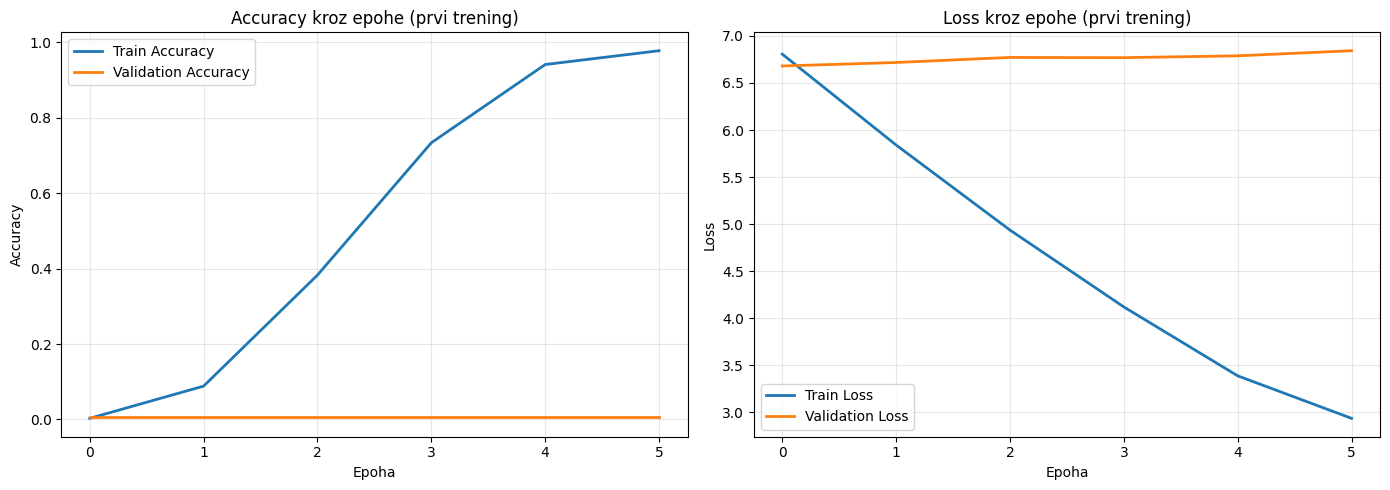

In [26]:
# Vizualizacija treninga
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Accuracy kroz epohe (prvi trening)')
axes[0].set_xlabel('Epoha')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Loss kroz epohe (prvi trening)')
axes[1].set_xlabel('Epoha')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Evaluacija na validacionom skupu
val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
print(f"Validacioni loss: {val_loss:.4f}")
print(f"Validaciona accuracy: {val_accuracy:.4f}")

# Predikcije za detaljniju analizu
val_generator.reset()
predictions = model.predict(val_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Accuracy i F1 score
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"\nAccuracy na validacionom skupu: {accuracy:.4f}")
print(f"Weighted F1 score: {f1:.4f}")

Validacioni loss: 6.6802
Validaciona accuracy: 0.0061
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 715ms/step

Accuracy na validacionom skupu: 0.0061
Weighted F1 score: 0.0001


-Analiza baseline modela

Cilj baseline modela bio je da se  proveri da li jednostavan CNN može da klasifikuje Pokemone na osnovu dostupnih slika. Model je treniran na 656 slika, podaljenih u 726 klasa, što znači da većina klasa ima samo 1-2 primera.
Rezultati evaluacije pokazuju:
- validaciona tačnost: 0,6% što je jednako nasumičnom pogađanju
- F1 score: 0,0001 model ne prikazuje nijednu klasu korektno

Ovakav rezultat je očekivan zato što:
- premali broj primera po klasi, od 726 klasa, većina ima 1-2 slike
- klasifikacioni modeli zahtevaju više primera po klasi da bi naučili varijacije
- overfitting: model je naučio trening podatke napamet, ali nije generalizovao



Kontrolna tačka 3

In [15]:
# Analiza osnovnih ID-jeva
df['base_id'] = df['pokemon_id'].astype(str).apply(lambda x: x.split('-')[0])

print(f"Ukupno slika: {len(df)}")
print(f"Broj osnovnih ID-jeva: {df['base_id'].nunique()}")
print(f"Broj varijanti: {df['pokemon_id'].nunique() - df['base_id'].nunique()}")

# Prikaz broja slika po osnovnom ID-ju
base_counts = df['base_id'].value_counts()
print(f"\nProsečan broj slika po osnovnom ID-ju: {base_counts.mean():.2f}")
print(f"Medijana: {base_counts.median()}")
print(f"Min: {base_counts.min()}")
print(f"Max: {base_counts.max()}")

Ukupno slika: 819
Broj osnovnih ID-jeva: 726
Broj varijanti: 0

Prosečan broj slika po osnovnom ID-ju: 1.13
Medijana: 1.0
Min: 1
Max: 6


In [16]:
# DCGAN dataset
# Parametri
IMG_SIZE = 128
BATCH_SIZE = 32
LATENT_DIM = 100
EPOCHS = 200

# Kreiranje dataset-a sa svim slikama
def create_dcgan_dataset(df, batch_size=BATCH_SIZE):
    paths = df['image_path'].values

    def load_image(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = (tf.cast(img, tf.float32) / 127.5) - 1.0  # normalizacija na [-1, 1]
        return img

    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(len(df))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Kreiranje dataset-a (sve slike)
dcgan_dataset = create_dcgan_dataset(df)
print("DCGAN dataset kreiran!")
for batch in dcgan_dataset.take(1):
    print(f"Batch shape: {batch.shape}")
    print(f"Vrednosti: [{batch.numpy().min():.2f}, {batch.numpy().max():.2f}]")

DCGAN dataset kreiran!
Batch shape: (32, 128, 128, 3)
Vrednosti: [-1.00, 1.00]


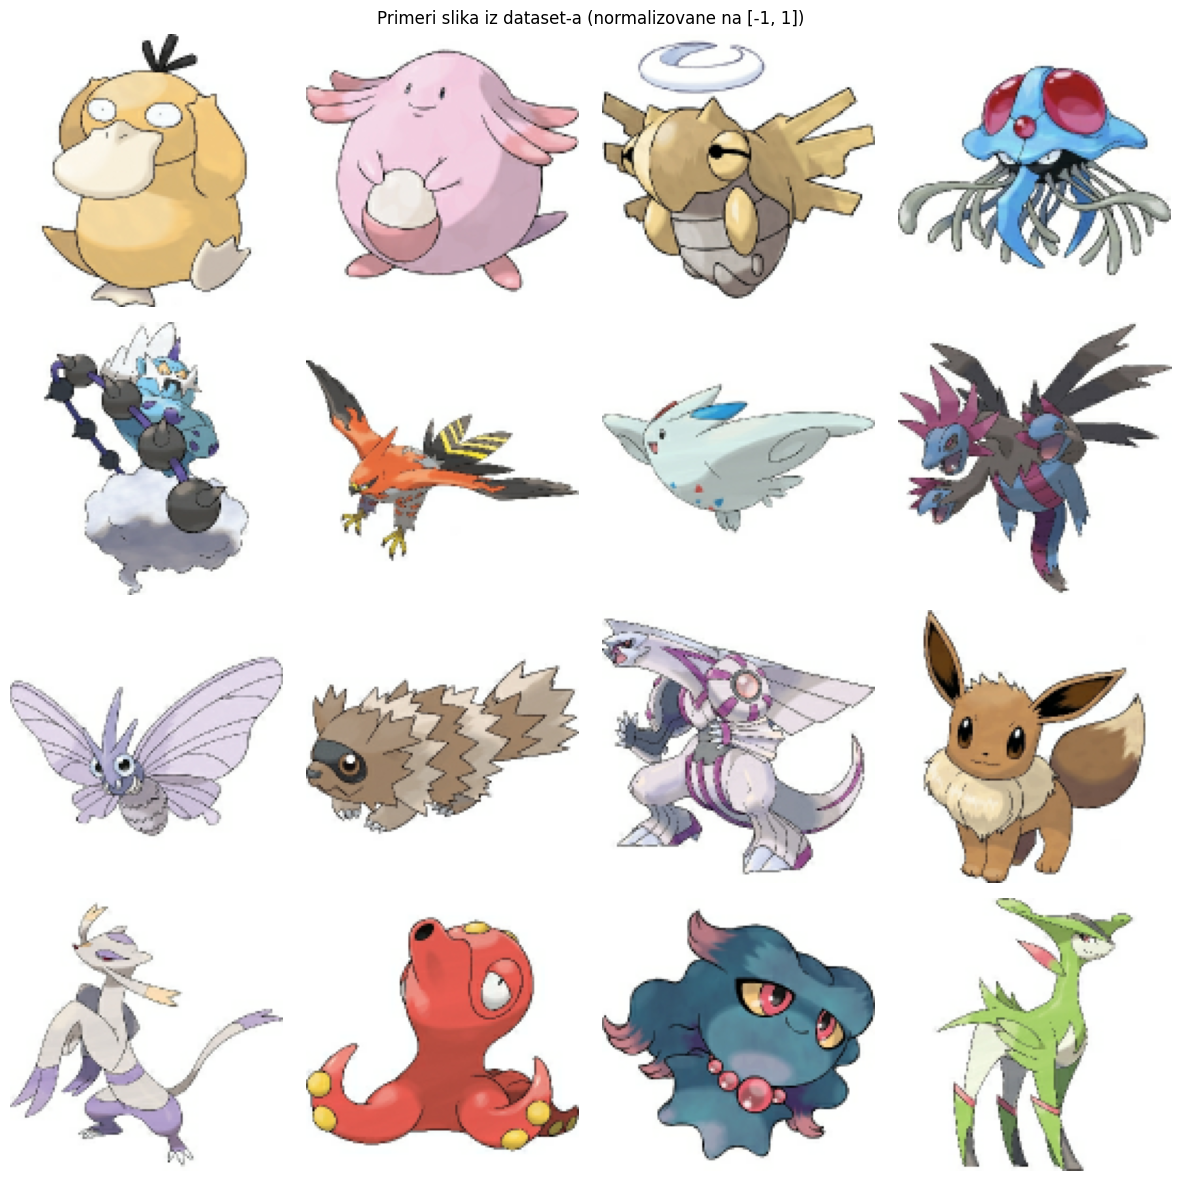

In [17]:
# Uzima jedan batch iz DCGAN dataset-a
sample_batch = next(iter(dcgan_dataset))

# Vraća slike u opseg [0,1] za prikaz
sample_images_display = (sample_batch.numpy() + 1) / 2.0

# Prikaz
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i in range(16):
    axes[i].imshow(sample_images_display[i])
    axes[i].axis('off')

plt.suptitle("Primeri slika iz dataset-a (normalizovane na [-1, 1])")
plt.tight_layout()
plt.show()

In [19]:
#DCGAN generator
from tensorflow.keras import layers

def build_dcgan_generator():
    model = tf.keras.Sequential([
        # Početni sloj (dense)
        layers.Dense(8 * 8 * 512, use_bias=False, input_shape=(LATENT_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Reshape u 3D tenzor
        layers.Reshape((8, 8, 512)),

        # Prvi upsampling (8x8 -> 16x16)
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Drugi upsampling (16x16 -> 32x32)
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Treći upsampling (32x32 -> 64x64)
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Četvrti upsampling (64x64 -> 128x128)
        layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Izlazni sloj (128x128, 3 kanala, tanh za [-1,1])
        layers.Conv2D(3, (4, 4), padding='same', activation='tanh', use_bias=False)
    ])
    return model

generator = build_dcgan_generator()
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     3,276,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 32)   │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 3)    │         1,536 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,196,608 (23.64 MB)

 Trainable params: 6,130,112 (23.38 MB)

 Non-trainable params: 66,496 (259.75 KB)

In [20]:
#DCGAN diskriminator
def build_dcgan_discriminator():
    model = tf.keras.Sequential([
        # Prvi konvolutivni blok
        layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Drugi blok
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Treći blok
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Četvrti blok
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Peti blok
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Spljošti i izlaz
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_dcgan_discriminator()
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,799,841 (10.68 MB)

 Trainable params: 2,797,921 (10.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [21]:
#Loss i optimizatori
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

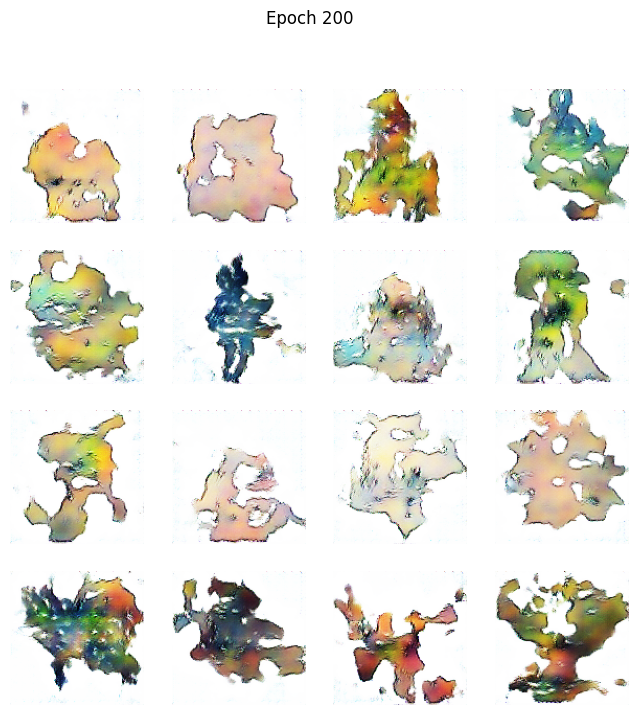

TRENING ZAVRŠEN!
Finalni G loss: 3.5528
Finalni D loss: 0.3397


In [22]:
#Trening

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

# Za praćenje
g_losses = []
d_losses = []

# Prikaz generisanih slika
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i].numpy() + 1) / 2.0)
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch+1}')
    plt.show()

# Seed za konzistentan prikaz
seed = tf.random.normal([16, LATENT_DIM])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Provera da li su generator i discriminator definisani
try:
    generator
    discriminator
    generator_loss
    discriminator_loss
    generator_optimizer
    discriminator_optimizer
    dcgan_dataset
except NameError as e:
    print(f"Greška: {e}")
    print("Morate prvo pokrenuti korake 1-4!")

# Glavna trening petlja
print("="*60)
print("POČINJEM DCGAN TRENING")
print("="*60)
print(f"Ukupno slika: {len(df)} | Batch size: {BATCH_SIZE} | Epoha: {EPOCHS}")
print(f"Batch-eva po epohi: {len(df) // BATCH_SIZE}")
print("="*60)

for epoch in range(EPOCHS):
    start = time.time()

    epoch_gen_loss = []
    epoch_disc_loss = []

    for image_batch in dcgan_dataset:
        gen_loss, disc_loss = train_step(image_batch)
        epoch_gen_loss.append(gen_loss)
        epoch_disc_loss.append(disc_loss)

    # Prosečni loss za epohu
    g_losses.append(np.mean(epoch_gen_loss))
    d_losses.append(np.mean(epoch_disc_loss))

    # Ispis svake epohe
    print(f'Epoch {epoch+1}/{EPOCHS} - G loss: {g_losses[-1]:.4f}, D loss: {d_losses[-1]:.4f} - {time.time()-start:.2f}s')

    # Prikaz slika svakih 10 epoha
    if (epoch + 1) % 10 == 0:
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch, seed)
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print(f'Generator loss: {g_losses[-1]:.4f}, Discriminator loss: {d_losses[-1]:.4f}')
        print(f'Proteklo vreme: {time.time()-start:.2f}s')

display.clear_output(wait=True)
generate_and_save_images(generator, epoch, seed)
print("="*60)
print("TRENING ZAVRŠEN!")
print("="*60)
print(f"Finalni G loss: {g_losses[-1]:.4f}")
print(f"Finalni D loss: {d_losses[-1]:.4f}")

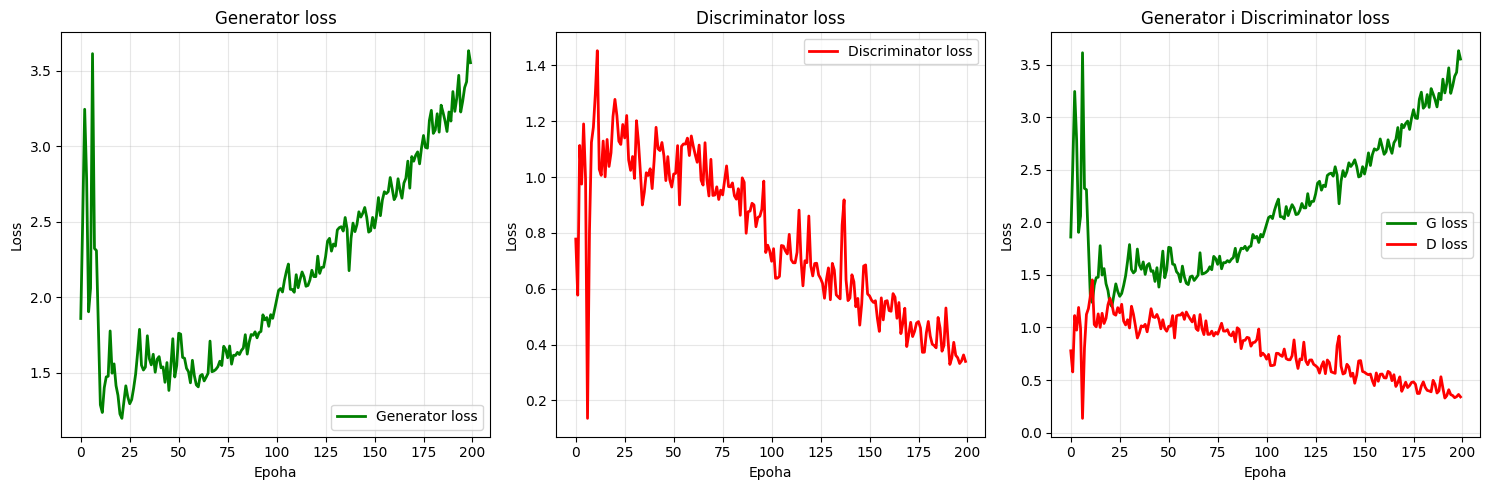

In [23]:
plt.figure(figsize=(15, 5))

# G loss
plt.subplot(1, 3, 1)
plt.plot(g_losses, label='Generator loss', color='green', linewidth=2)
plt.xlabel('Epoha')
plt.ylabel('Loss')
plt.title('Generator loss')
plt.legend()
plt.grid(True, alpha=0.3)

# D loss
plt.subplot(1, 3, 2)
plt.plot(d_losses, label='Discriminator loss', color='red', linewidth=2)
plt.xlabel('Epoha')
plt.ylabel('Loss')
plt.title('Discriminator loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Oba zajedno
plt.subplot(1, 3, 3)
plt.plot(g_losses, label='G loss', color='green', linewidth=2)
plt.plot(d_losses, label='D loss', color='red', linewidth=2)
plt.xlabel('Epoha')
plt.ylabel('Loss')
plt.title('Generator i Discriminator loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Generiše 32 slike
n_samples = 32
noise = tf.random.normal([n_samples, LATENT_DIM])
generated_images = generator(noise, training=False)

# Prikaz sa više detalja
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.ravel()

for i in range(n_samples):
    img = (generated_images[i].numpy() + 1) / 2.0
    axes[i].imshow(img)
    axes[i].axis('off')

plt.suptitle("Generisane slike - DCGAN nakon 200 epoha", fontsize=16)
plt.tight_layout()
plt.show()

# Prikaz nekoliko slika uvećano
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i in range(8):
    img = (generated_images[i].numpy() + 1) / 2.0
    axes[i].imshow(img)
    axes[i].set_title(f"Slika {i+1}")
    axes[i].axis('off')

plt.suptitle("Generisane slike - uvećani prikaz", fontsize=16)
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.